In [1]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 51.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.0 MB/s 
     |████████████████████████████████| 61 kB 513 kB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=c7514176a463ce64d4f066295c90e7654f54723aeecbc86b43f2eef0a479c2b4
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
import re # for cleaning Resume_str
import pandas as pd
import csv
import torch

### Load file

In [18]:
file_path = 'Resume.csv'
df = pd.read_csv(file_path, error_bad_lines=False)

### Data observation

In [19]:
df.columns

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')

In [20]:
df = df.drop(columns=['Resume_html'])
df.columns

Index(['ID', 'Resume_str', 'Category'], dtype='object')

In [ ]:
df.head(5)

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [ ]:
df.Resume_str[0]

"         HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss pr

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2484 non-null   int64 
 1   Resume_str  2484 non-null   object
 2   Category    2484 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


In [21]:
df_gb = df.groupby('Category')
print('Number of Category: {}'.format(df_gb.ngroups))
print(df_gb.size())

Number of Category: 24
Category
ACCOUNTANT                118
ADVOCATE                  118
AGRICULTURE                63
APPAREL                    97
ARTS                      103
AUTOMOBILE                 36
AVIATION                  117
BANKING                   115
BPO                        22
BUSINESS-DEVELOPMENT      120
CHEF                      118
CONSTRUCTION              112
CONSULTANT                115
DESIGNER                  107
DIGITAL-MEDIA              96
ENGINEERING               118
FINANCE                   118
FITNESS                   117
HEALTHCARE                115
HR                        110
INFORMATION-TECHNOLOGY    120
PUBLIC-RELATIONS          111
SALES                     116
TEACHER                   102
dtype: int64


### Preprocess data

In [22]:
def clean_spaces(s):
    s = ' '.join(re.split('[ ]+', s.strip()))

    return s

# Todo:
# add more preprocess function for preprocessor

def preprocessor(df):
    df['Resume_str'] = df['Resume_str'].apply(lambda x: clean_spaces(x))

    return df

In [23]:
df = preprocessor(df)

### Map Resume_str to a embedding (vector)

In [24]:
import torch
from sentence_transformers import SentenceTransformer, util

# doc2vec
# word2vec (200, 128) -> 128, (50, 128) -> 128, (120, 128) -> 128

In [25]:
model = SentenceTransformer('all-distilroberta-v1')
model.max_seq_length = 512

# Corpus with resumes
Resume_corpus = df['Resume_str'].tolist()

# Calculate the embeddng for every resume_str
corpus_embeddings = model.encode(Resume_corpus)
print(corpus_embeddings.shape)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

(2484, 768)


In [26]:
import numpy as np
np.save('corpus_embeddings.npy', corpus_embeddings)

In [27]:
import numpy as np

corpus_embeddings = np.load('corpus_embeddings.npy')

### Apply k-Means clustering on the embeddings

In [28]:
import numpy as np
from sklearn.cluster import KMeans

num_clusters = df.groupby('Category').ngroups # 24
clustering_model = KMeans(n_clusters=num_clusters)

clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_ # Get the clustered label for each embedding
print(cluster_assignment.shape)

clustered_resumes = [[] for i in range(num_clusters)] # Will contain embeddings for each cluster  
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_resumes[cluster_id].append(Resume_corpus[sentence_id])

(2484,)


In [29]:
print('Number of resumes in each cluster')
for i, cluster in enumerate(clustered_resumes):
    print('Cluster {}: {}'.format(i+1, len(cluster)))

Number of resumes in each cluster
Cluster 1: 58
Cluster 2: 119
Cluster 3: 92
Cluster 4: 52
Cluster 5: 117
Cluster 6: 196
Cluster 7: 116
Cluster 8: 134
Cluster 9: 83
Cluster 10: 75
Cluster 11: 100
Cluster 12: 99
Cluster 13: 54
Cluster 14: 90
Cluster 15: 105
Cluster 16: 38
Cluster 17: 117
Cluster 18: 120
Cluster 19: 111
Cluster 20: 171
Cluster 21: 90
Cluster 22: 114
Cluster 23: 141
Cluster 24: 92


In [ ]:
# Todo:
# 1. Visualize the clustered result
# 2. Try applying other clustering methods
# 3. Other stuff that can perform on cluster, e.g. Topic modeling?

### Visualize the clustered result

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

No handles with labels found to put in legend.


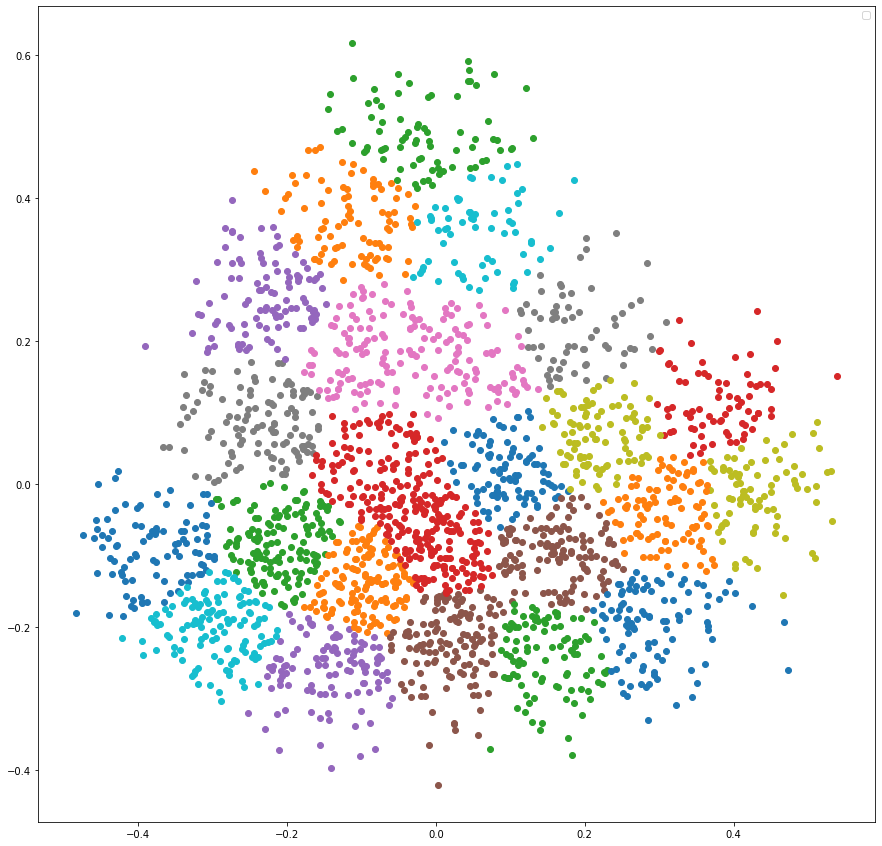

In [31]:
# PCA降成2維 -> kMeans -> 畫圖
# 768 -> 2

pca = PCA(2)
corpus_embeddings_2d = pca.fit_transform(corpus_embeddings) # (2484, 768) -> (2484, 2)

num_clusters = df.groupby('Category').ngroups # 24

clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings_2d)
cluster_assignment = clustering_model.labels_

plt.figure(figsize=(15, 15))

for i in range(num_clusters):
  plt.scatter(corpus_embeddings_2d[cluster_assignment==i, 0], corpus_embeddings_2d[cluster_assignment==i, 1])

plt.legend()
plt.show()

No handles with labels found to put in legend.


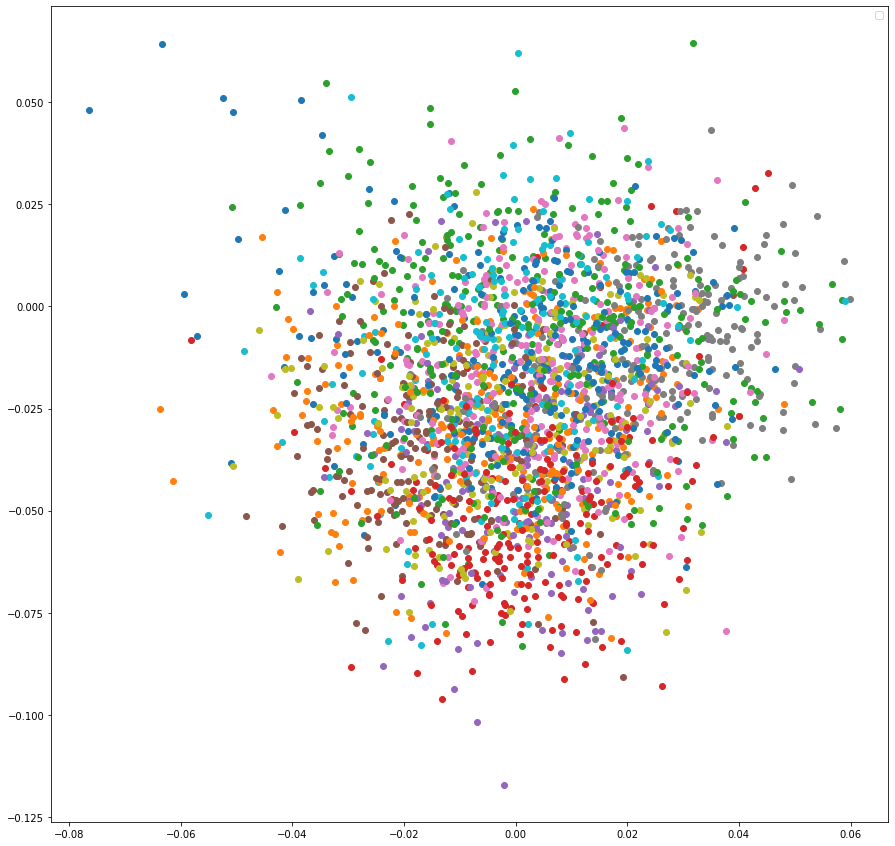

In [38]:
# kMeans -> 隨機挑2維畫圖

num_clusters = df.groupby('Category').ngroups # 24

clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings) # (2484, 768)
cluster_assignment = clustering_model.labels_

plt.figure(figsize=(15, 15))

for i in range(num_clusters):
  plt.scatter(corpus_embeddings[cluster_assignment==i, 2], corpus_embeddings[cluster_assignment==i, 1])

plt.legend()
plt.show()

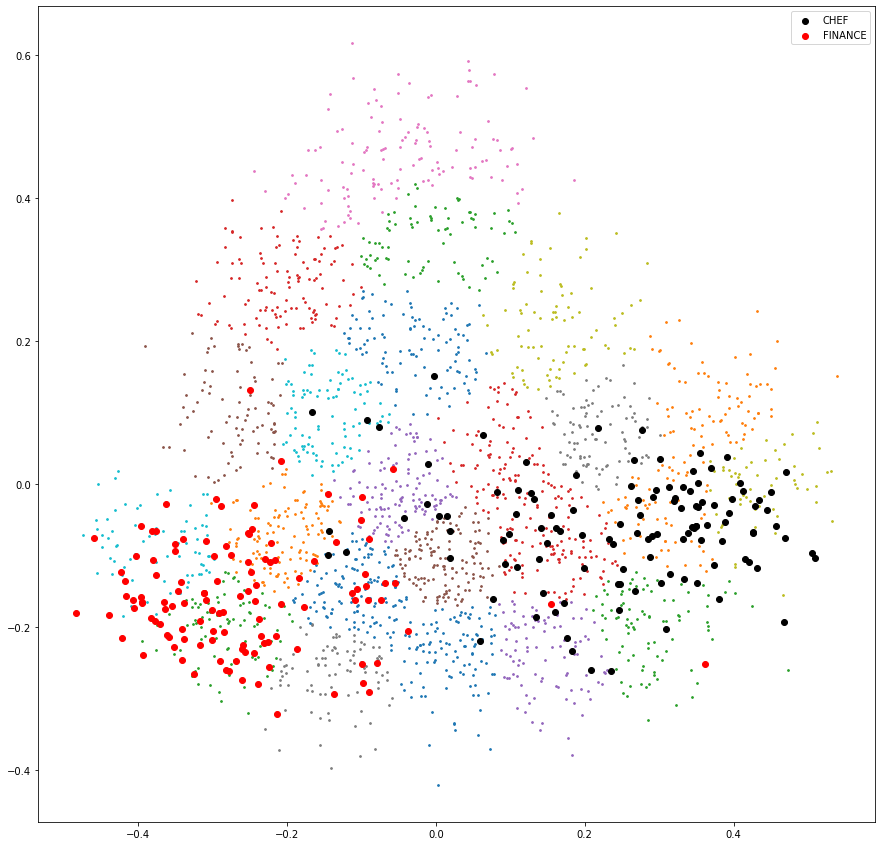

In [41]:
# PCA降成2維 -> kMeans -> 畫圖 -> 加上某職業
domain = 'CHEF'

pca = PCA(2)
corpus_embeddings_2d = pca.fit_transform(corpus_embeddings)

num_clusters = df.groupby('Category').ngroups # 24

clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings_2d)
cluster_assignment = clustering_model.labels_

plt.figure(figsize=(15, 15))

for i in range(num_clusters):
  plt.scatter(corpus_embeddings_2d[cluster_assignment==i, 0], corpus_embeddings_2d[cluster_assignment==i, 1], s=3)

df_group = df_gb.get_group('CHEF')
group_corpus_embeddings = corpus_embeddings_2d[df_group.index]
plt.scatter(group_corpus_embeddings[:, 0], group_corpus_embeddings[:, 1], label='CHEF', c='black')

df_group = df_gb.get_group('FINANCE')
group_corpus_embeddings = corpus_embeddings_2d[df_group.index]
plt.scatter(group_corpus_embeddings[:, 0], group_corpus_embeddings[:, 1], label='FINANCE', c='red')


plt.legend()
plt.show()

### Find the cross domain (category) resumes

In [ ]:
def get_avg_embeddings(df_gb, group_name):
    print('Group name: {}'.format(group_name))
    df_group = df_gb.get_group(group_name)

    # Resume corpus of groups
    group_corpus = df_group['Resume_str'].tolist()

    group_corpus_embeddings = model.encode(group_corpus, convert_to_tensor=True)
    print('Shape of group_corpus_embeddings: {}'.format(group_corpus_embeddings.shape))

    group_avg_embedding = torch.mean(group_corpus_embeddings, dim=0, keepdim=True)
    print('Shape of group_avg_embeddings: {}'.format(group_avg_embedding.shape))

    return group_avg_embedding

In [ ]:
def get_avg_embeddings_revised(df_gb, corpus_embeddings, group_name):
  df_group = df_gb.get_group(group_name)
  group_corpus_embeddings = corpus_embeddings[df_group.index] # (110, 768)
  group_avg_embedding = np.mean(group_corpus_embeddings, axis=0)
  return group_avg_embedding

In [ ]:
def search_resumeID(query_embedding, corpus_embeddings, top_k):
  hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
  hits = hits[0]
  for hit in hits:
    print(df.ID[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

In [ ]:
corpus_embeddings = model.encode(Resume_corpus)

A  = [ 1, 2, 3, ...] # 768
B  = [ 8, 2, 1, ...] # 768
avg = [4.5, 2, 2, ...]

In [ ]:
ACCNT_avg_embedding = get_avg_embeddings_revised(df_gb, corpus_embeddings, 'ACCOUNTANT')
IT_avg_embedding = get_avg_embeddings_revised(df_gb, corpus_embeddings, 'INFORMATION-TECHNOLOGY')

In [ ]:
query_embedding = (ACCNT_avg_embedding + IT_avg_embedding) / 2
search_resumeID(query_embedding, corpus_embeddings, top_k=5)

27637576 (Score: 0.8978)
11441764 (Score: 0.8915)
23636277 (Score: 0.8828)
22492537 (Score: 0.8826)
25127518 (Score: 0.8812)


In [ ]:
# Todo:
# 1. Cross 3 or more domain (categories)
# 2. Find qualitative example (we can show in report/presentation)
# 3. Other vector (embedding) operation to perform, i.e., other task

### Cross 3 or more domain (categories)

In [ ]:
def cross_domain(df_gb, domains, corpus_embeddings, top_k):
  avg_embeddings = []
  for domain in domains:
    avg_embeddings.append(get_avg_embeddings_revised(df_gb, corpus_embeddings, domain))
  query_embedding = np.mean(avg_embeddings, axis=0) # 768
  search_resumeID(query_embedding, corpus_embeddings, top_k)

In [ ]:
cross_domain(df_gb, ['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE'], corpus_embeddings, 5)

29297393 (Score: 0.8771)
23416654 (Score: 0.8760)
25127518 (Score: 0.8737)
28724469 (Score: 0.8710)
59777056 (Score: 0.8691)
